In [10]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import emoji
import preprocessor as p
import truecase
import nltk
from sklearn.utils import resample

p.set_options(p.OPT.URL)
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/eliasschuhmacher/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Preprocessing Function

In [6]:
def lowercasing(sentence):
    return str(sentence).lower()

def truecasing(sentence):
    """ Alternative function to 'lowercasing().
        Instead of turning everything into lower case, the grammatically true case
        is used."""
    return truecase.get_true_case(str(sentence))

def rm_whitespace(sentence):
    return str(sentence).strip()

def replace_emoji(sentence):
    return emoji.demojize(str(sentence))

def replace_url(sentence):
    return p.tokenize(str(sentence))

def replace_url(sentence):
    new_text = []
    for t in sentence.split(" "):
        #t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [7]:
def preprocessing(s):
    #s = lowercasing(s)
    #s = truecasing(s)
    s = rm_whitespace(s)
    s = replace_emoji(s)    
    s = replace_url(s)
    return s


#e.g.
s = ' Preprocessor is #awesome 👍 https://github.com/s/preprocessor '
preprocessing(s)

'Preprocessor is #awesome :thumbs_up: http'

## Encoding Attributes

In [8]:
def one_hot_encoding(df, column):
    """ One-hot encoding for a column in a dataframe """
    one_hot_df = pd.get_dummies(df[column])
    df[column] = one_hot_df.apply(lambda x: x.argmax(), axis=1)
    return df


# Files cleaning

In [9]:
datafolder = Path("./data/practise_data")
print(list(datafolder.rglob('*.csv')))

train_f= Path('data/practise_data/development_train.csv')
test_f= Path('data/practise_data/development_test.csv')
full_f= Path('data/full_data/full_data.csv')
test_f= Path('data/test_data/politicES_phase_2_test_public.csv')


[PosixPath('data/practise_data/development_test.csv'), PosixPath('data/practise_data/development_train.csv'), PosixPath('data/practise_data/cleaned/cleaned_encoded_development_train.csv'), PosixPath('data/practise_data/cleaned/cleaned_encoded_development_test.csv'), PosixPath('data/practise_data/cleaned/_old/cleaned_encoded_development_train.csv'), PosixPath('data/practise_data/cleaned/_old/cleaned_development_train.csv'), PosixPath('data/practise_data/cleaned/_old/cleaned_encoded_development_test.csv'), PosixPath('data/practise_data/cleaned/_old/cleaned_development_test.csv')]


In [10]:
def clean_df(df, f_path):
    df["cleaned_tweet"] = df["tweet"].apply(lambda s: preprocessing(s))

    df = one_hot_encoding(df, 'gender')
    df = one_hot_encoding(df, 'profession')
    df = one_hot_encoding(df, 'ideology_binary')
    df = one_hot_encoding(df, 'ideology_multiclass')

    df_path = f_path.parent/"cleaned"/f"cleaned_encoded_{f_path.name}"
    df_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(df_path)
    return df_path

In [11]:
def clean_df_test_data(df, f_path):
    df["cleaned_tweet"] = df["tweet"].apply(lambda s: preprocessing(s))

    df_path = f_path.parent/"cleaned"/f"cleaned_{f_path.name}"
    df_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(df_path)
    return df_path

In [8]:
# def clean_df(df, f_path):
#     df["cleaned_tweet"] = df["tweet"].apply(lambda s: preprocessing(s))

#     df_path = f_path.parent/"cleaned"/f"cleaned_{f_path.name}"
#     df_path.parent.mkdir(parents=True, exist_ok=True)
#     df.to_csv(df_path)
#     return df_path

In [9]:
train_df = pd.read_csv(train_f)
test_df = pd.read_csv(test_f)
full_df = pd.read_csv(full_f)

In [10]:
clean_df(train_df,train_f)
clean_df(test_df,test_f)
clean_df(full_df,full_f)

PosixPath('data/full_data/cleaned/cleaned_encoded_full_data.csv')

In [13]:
test_df = pd.read_csv(test_f)
clean_df_test_data(test_df,test_f)

PosixPath('data/test_data/cleaned/cleaned_politicES_phase_2_test_public.csv')

# Splitting the data into train and validation

In [44]:
# This function samples an equal number of tweets from every possible combination of the columns 'gender', 'profession', 'ideology_multiclass'.
def equal_combinations_sample_df(df, combination_cols, n_per_combination, random_state=42):
    """ Sample an equal number of tweets from every possible combination of the columns in 'combination_cols'.
        The number of tweets per combination is specified by 'n_per_combination'.
        The resulting dataframe is not shuffled.
    """
    try:
        df = df.groupby(combination_cols).apply(lambda x: x.sample(n_per_combination, replace=False, random_state=random_state))
    except ValueError:
        print(f"Warning: not enough tweets to sample {n_per_combination} tweets per combination. Falling back to sampling with replacement.")
        df = df.groupby(combination_cols).apply(lambda x: x.sample(n_per_combination, replace=True, random_state=random_state))
    
    df = df.reset_index(drop=True)
    return df



# This function splits the full dataset into a train and validation set.
def split_df(read_f_path, write_file_name, combination_cols, n_val_per_feature_combination, random_state=42):
    """ Split the full dataset into a train and validation set.
        The validation set is sampled from every possible combination of the columns in 'combination_cols'.
        The number of tweets per combination is specified by 'n_val_per_feature_combination'.
        The resulting train dataframe is shuffled.
    """
    # Read the full dataset
    df = pd.read_csv(read_f_path)

    # Create validation set with equal number of tweets per feature combination
    val_df = equal_combinations_sample_df(df, combination_cols, n_val_per_feature_combination, random_state)

    # Create train set by dropping the validation set
    train_df = df.drop(val_df.index)

    # Shuffle the train set
    train_df = train_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    # Drop the 'Unnamed: 0' column
    train_df = train_df.drop(columns=['Unnamed: 0'])
    val_df = val_df.drop(columns=['Unnamed: 0'])

    # Save the train and validation sets
    train_path = read_f_path.parent/f"train_{write_file_name}.csv"
    val_path = read_f_path.parent/f"val_{write_file_name}.csv"
    train_path.parent.mkdir(parents=True, exist_ok=True)
    val_path.parent.mkdir(parents=True, exist_ok=True)
    train_df.to_csv(train_path)
    val_df.to_csv(val_path)
    return train_path, val_path

In [12]:
full_cleaned_encoded_f= Path('data/full_data/cleaned/cleaned_encoded_full_data.csv')

split_df(read_f_path = full_cleaned_encoded_f,
        write_file_name = 'clean_encoded',
        combination_cols = ['gender', 'profession', 'ideology_multiclass'],
        n_val_per_feature_combination = 200)

(PosixPath('data/full_data/cleaned/train_clean_encoded.csv'),
 PosixPath('data/full_data/cleaned/val_clean_encoded.csv'))

# Inspect the full dataset

In [23]:
from pathlib import Path
import pandas as pd
import numpy as np

fulldata= Path('data/full_data/cleaned/_old/cleaned_full_data.csv')
df = pd.read_csv(fulldata)

# Create array to store all the combinations
n_gender = df['gender'].nunique()
n_profession = df['profession'].nunique()
n_ideology_multiclass = df['ideology_multiclass'].nunique()

combinations = np.zeros((n_gender, n_profession, n_ideology_multiclass))


genders  = ['female','male']
professions = ['politician','journalist','celebrity']
ideology_multiclasses = ['left','right','moderate_left', 'moderate_right']


for i, gender in enumerate(genders):
    for j, profession in enumerate(professions):
        for k, ideology in enumerate(ideology_multiclasses):
            selected_df = df.iloc[
                list((df.gender == gender) & \
                    (df.profession == profession)& \
                    (df.ideology_multiclass == ideology)), 
                :,
            ]
            print(f"{gender},{profession},{ideology}",len(selected_df))
            combinations[i,j,k] = len(selected_df)



female,politician,left 6240
female,politician,right 3280
female,politician,moderate_left 8000
female,politician,moderate_right 6560
female,journalist,left 7040
female,journalist,right 1440
female,journalist,moderate_left 15040
female,journalist,moderate_right 9280
female,celebrity,left 320
female,celebrity,right 0
female,celebrity,moderate_left 2720
female,celebrity,moderate_right 640
male,politician,left 9120
male,politician,right 5520
male,politician,moderate_left 11280
male,politician,moderate_right 10160
male,journalist,left 11600
male,journalist,right 10480
male,journalist,moderate_left 25120
male,journalist,moderate_right 30800
male,celebrity,left 80
male,celebrity,right 640
male,celebrity,moderate_left 3840
male,celebrity,moderate_right 800


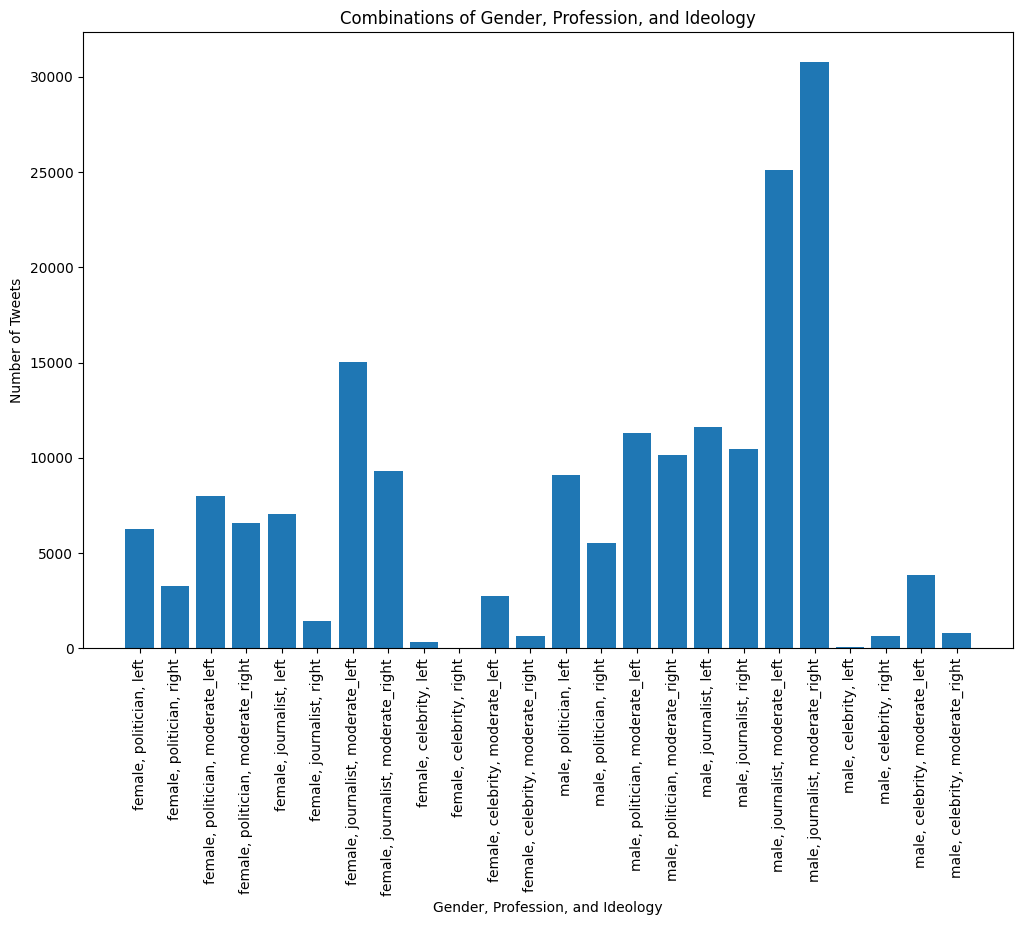

In [24]:
import matplotlib.pyplot as plt

# Flatten the combinations array
combinations_flat = combinations.flatten()

# Create a list of labels for the x-axis
labels = [f"{g}, {p}, {i}" for g in genders for p in professions for i in ideology_multiclasses]

# Create a bar chart with the flattened combinations array and the labels
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(labels, combinations_flat)

# Set the x-tick labels to be rotated for better readability
plt.xticks(rotation=90)

# Set the title and axis labels
plt.title("Combinations of Gender, Profession, and Ideology")
plt.xlabel("Gender, Profession, and Ideology")
plt.ylabel("Number of Tweets")

plt.show()

# Upsampling the training data

In [3]:
def upsample_df(df, features):
    # Determine the maximum number of samples for any feature combination
    max_samples = df.groupby(features).size().max()
    
    # Create an empty dataframe to store the upsampled data
    balanced_df = pd.DataFrame(columns=df.columns)
    
    # Loop over each unique combination of features
    for i, group in df.groupby(features):
        # Determine the number of samples to generate to make the data balanced
        n_samples = max_samples - len(group)
        
        # If the number of samples for the current combination is less than the maximum number of samples for any combination, upsample the data
        if n_samples > 0:
            # Upsample the data
            upsampled_group = resample(group, replace=True, n_samples=n_samples)
            
            # Append the upsampled data to the balanced dataframe
            balanced_df = pd.concat([balanced_df, group, upsampled_group], ignore_index=True)
        else:
            # If the number of samples for the current combination is already at the maximum, just append the group to the balanced dataframe
            balanced_df = pd.concat([balanced_df, group], ignore_index=True)
    
    
    

    # Cast columns to their original data types
    for col in df.columns:
        balanced_df[col] = balanced_df[col].astype(df[col].dtype)

    # Drop the 'Unnamed: 0' column
    balanced_df = balanced_df.drop(columns=['Unnamed: 0'])
    
    return balanced_df

In [4]:
path= Path('data/full_data/cleaned/train_clean_encoded.csv')
df = pd.read_csv(path)


df = upsample_df(df, ['gender', 'profession', 'ideology_multiclass'])
df.to_csv('data/full_data/cleaned/train_clean_encoded_balanced.csv')

In [8]:
# Create array to store all the combinations
n_gender = df['gender'].nunique()
n_profession = df['profession'].nunique()
n_ideology_multiclass = df['ideology_multiclass'].nunique()

combinations = np.zeros((n_gender, n_profession, n_ideology_multiclass))


genders  = [0,1]
professions = [0,1,2]
ideology_multiclasses = [0,1,2,3]


for i, gender in enumerate(genders):
    for j, profession in enumerate(professions):
        for k, ideology in enumerate(ideology_multiclasses):
            selected_df = df.iloc[
                list((df.gender == gender) & \
                    (df.profession == profession)& \
                    (df.ideology_multiclass == ideology)), 
                :,
            ]
            print(f"{gender},{profession},{ideology}",len(selected_df))
            combinations[i,j,k] = len(selected_df)

0,0,0 30080
0,0,1 30080
0,0,2 30080
0,0,3 0
0,1,0 30080
0,1,1 30080
0,1,2 30080
0,1,3 30080
0,2,0 30080
0,2,1 30080
0,2,2 30080
0,2,3 30080
1,0,0 30080
1,0,1 30080
1,0,2 30080
1,0,3 30080
1,1,0 30080
1,1,1 30080
1,1,2 30080
1,1,3 30080
1,2,0 30080
1,2,1 30080
1,2,2 30080
1,2,3 30080


In [9]:
# Flatten the combinations array
combinations_flat = combinations.flatten()

# Create a list of labels for the x-axis
labels = [f"{g}, {p}, {i}" for g in genders for p in professions for i in ideology_multiclasses]

# Create a bar chart with the flattened combinations array and the labels
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(labels, combinations_flat)

# Set the x-tick labels to be rotated for better readability
plt.xticks(rotation=90)

# Set the title and axis labels
plt.title("Combinations of Gender, Profession, and Ideology")
plt.xlabel("Gender, Profession, and Ideology")
plt.ylabel("Number of Tweets")

plt.show()

NameError: name 'plt' is not defined